In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
from kaggle.api.kaggle_api_extended import KaggleApi
import pickle

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_DQ_fe.csv'


ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]

data = pd.read_csv(dataset_path + dataset_file)

In [7]:
df=data.copy()
df.shape

(328966, 227)

In [8]:
df['clase_peso'] = 1.0
df['clase_binaria'] = 0
df['clase_binaria'] = np.where(df['clase_ternaria'] == 'CONTINUA', 0, 1)

df.loc[df['clase_binaria'] == 1, 'clase_peso'] = 1.0001

In [9]:
## funciones generales
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.0001, ganancia_acierto, 0) - np.where(weight < 1.0001, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [10]:
train_data = df[df['foto_mes'] == mes_train]
test_data = df[df['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_train_binaria = train_data['clase_binaria']
w_train = train_data['clase_peso']

X_test_m1 = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test_binaria_m1 = test_data['clase_binaria']
w_test_m1 = test_data['clase_peso']

In [ ]:
#optimizacion M2_fe_todas

In [11]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 50, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 500, 4000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.3, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'early_stopping_rounds': int(50 + 5 / learning_rate),
        'verbose': -1
    }

    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria, # todos los baja como 1
                              weight=w_train)
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100000, # modificar, subit y subir
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimizacion_LGBM_competencia_01.db"
study_name = "optimizacion_lgbm_M2_fe_todas"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-06 23:13:02,134] Using an existing study with name 'optimizacion_lgbm_M2_fe_todas' instead of creating a new one.


In [12]:
study.optimize(objective, n_trials=100) # subir subir

[I 2024-10-06 23:13:19,850] Trial 1 finished with value: 354725000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.28306992198111375, 'min_data_in_leaf': 2691, 'feature_fraction': 0.5704365535880987, 'bagging_fraction': 0.4843312614981888}. Best is trial 1 with value: 354725000.0.
[I 2024-10-06 23:13:47,673] Trial 2 finished with value: 366968000.0 and parameters: {'num_leaves': 227, 'learning_rate': 0.09397317292138634, 'min_data_in_leaf': 3441, 'feature_fraction': 0.41981770157388276, 'bagging_fraction': 0.4561362244348969}. Best is trial 2 with value: 366968000.0.
[I 2024-10-06 23:14:00,594] Trial 3 finished with value: 356790000.0 and parameters: {'num_leaves': 243, 'learning_rate': 0.2870340883662862, 'min_data_in_leaf': 2603, 'feature_fraction': 0.5546204105557407, 'bagging_fraction': 0.8977471447323908}. Best is trial 2 with value: 366968000.0.
[I 2024-10-06 23:14:11,134] Trial 4 finished with value: 357014000.0 and parameters: {'num_leaves': 138, 'learning_rate': 0.2543

KeyboardInterrupt: 

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
plot_param_importances(study)

In [15]:
plot_slice(study)

In [16]:
study.best_trial

FrozenTrial(number=52, state=1, values=[372918000.0], datetime_start=datetime.datetime(2024, 10, 6, 23, 38, 8, 645688), datetime_complete=datetime.datetime(2024, 10, 6, 23, 38, 54, 407914), params={'num_leaves': 153, 'learning_rate': 0.05614872275644336, 'min_data_in_leaf': 2162, 'feature_fraction': 0.3827015783205026, 'bagging_fraction': 0.966996248181506}, user_attrs={'best_iter': 143}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=400, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=4000, log=False, low=500, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None)}, trial_id=153, value=None)

In [17]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [18]:
### guardo el modelo
model_lgb.save_model(modelos_path + 'lgbm_M2_fe_todas.txt')

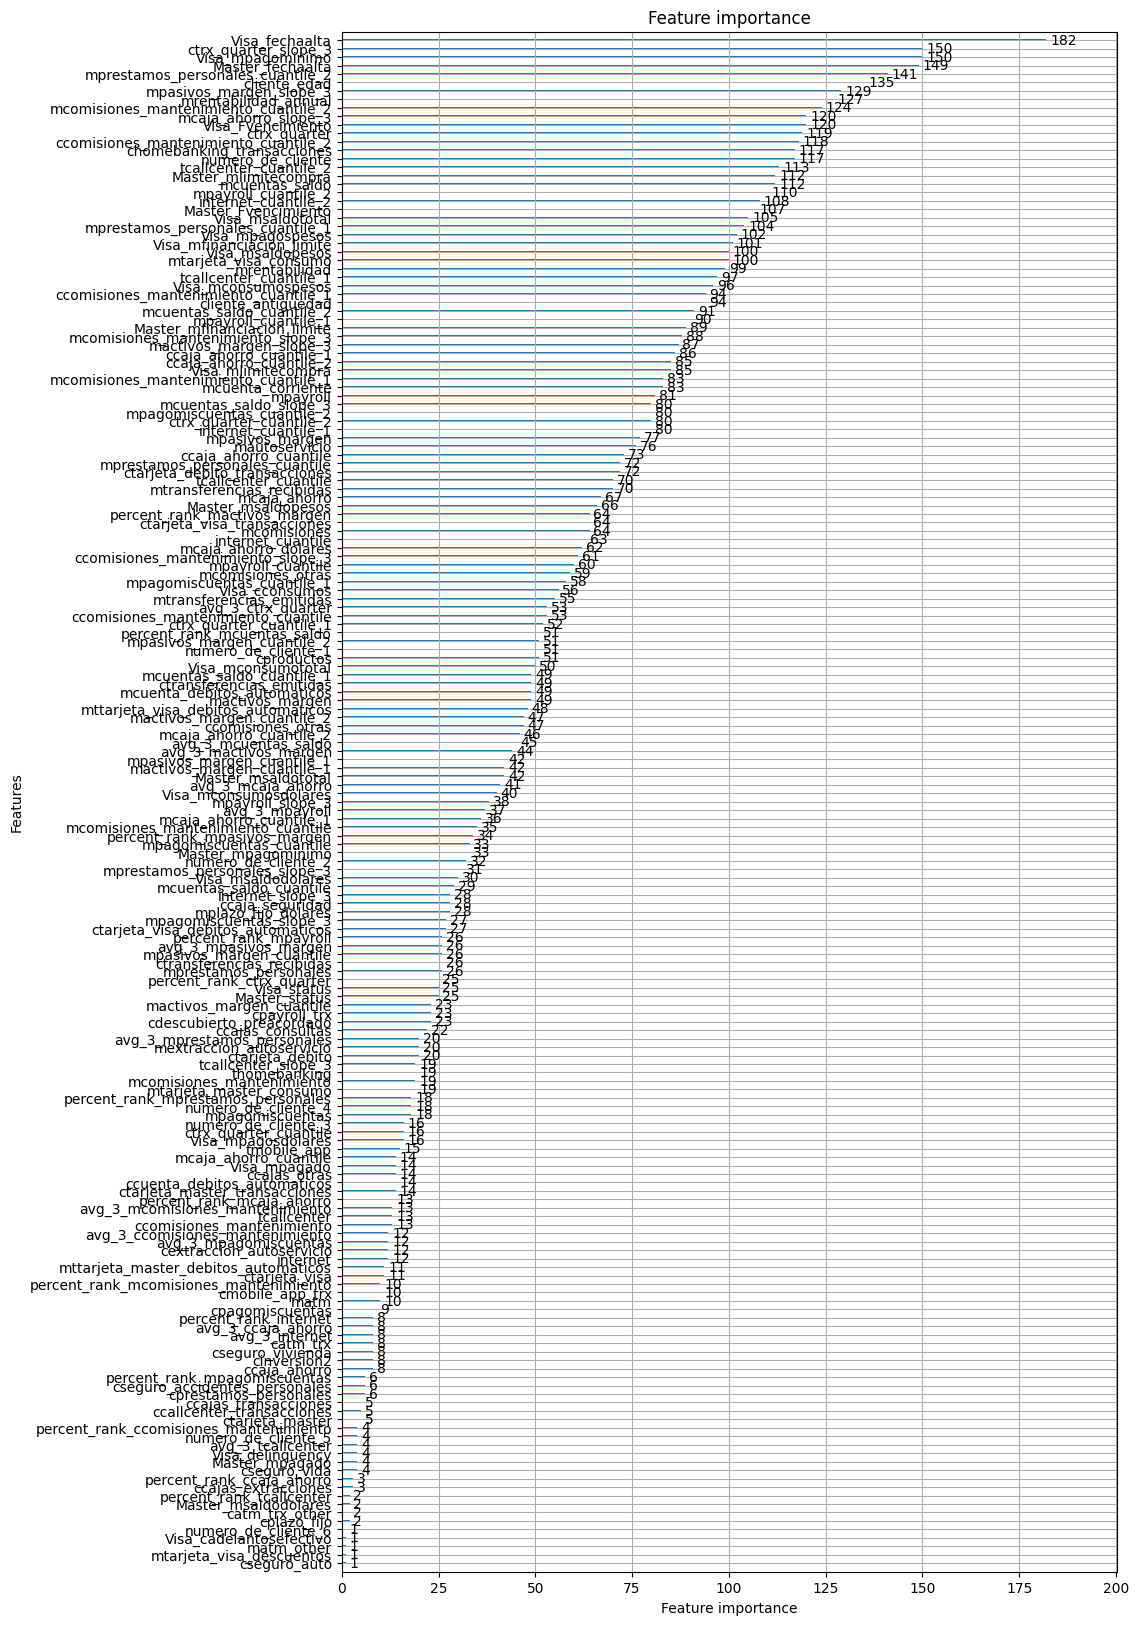

In [19]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()

In [20]:
importances = model_lgb.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 1]

,feature,importance
118,Visa_fechaalta,182
122,Visa_mpagominimo,150
199,ctrx_quarter_slope_3,150
101,Master_fechaalta,149
157,mprestamos_personales_cuantile_2,141
...,...,...
223,percent_rank_ccaja_ahorro,3
87,catm_trx_other,2
34,cplazo_fijo,2
98,Master_msaldodolares,2


In [22]:
predicciones = model_lgb.predict(X_test_m1)

clases = np.where(predicciones >= 0.040, 1, 0)


resultados = pd.DataFrame({
    'numero_de_cliente': X_test_m1['numero_de_cliente'],
    'Predicted': clases
})

In [23]:
resultados["Predicted"].value_counts()

Predicted
0    155601
1      9275
Name: count, dtype: int64

In [24]:
api = KaggleApi()
api.authenticate()

In [25]:
#L. Predecimos Junio.
#i. Predecimos propiamente dicho.
predicciones = model_lgb.predict(X_test_m1)
#ii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
X_test_m1['Probabilidad'] = predicciones
#iii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
tb_entrega = X_test_m1.sort_values(by='Probabilidad', ascending=False)
#iv. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
cortes = range(8000,13000,250)
#v. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
num_subida_kaggle = 17
for envios in cortes:
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
    
    print("Cantidad de clientes {}".format(envios))
    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "M2_fe_todas{}.csv".format(num_subida_kaggle)
    ruta_archivo= "../../../exp/{}".format(nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)
    
    num_subida_kaggle += 1
    
    #3. Envío a Kaggle.
    #a. Defino los parámetros claves.
    mensaje = f'Archivo {nombre_archivo}.Punto_corte: {envios}.'
    competencia = 'dm-ey-f-2024-primera'
    #c. Subo la Submission.
    while True:
        try:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
            break
        except ApiException as e:
            print(f"Error: {e}")  # Imprime la excepción completa para ver qué atributos tiene
            if e.status == 429:  # Reemplaza esto si `status` no es correcto
                print("Rate limit exceeded. Retrying after 30 seconds...")
                time.sleep(30)
            else:
                raise e  # Re-raise other exceptions

Cantidad de clientes 8000


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.21MB/s]


Submission successful!
Cantidad de clientes 8250


100%|██████████| 2.08M/2.08M [00:02<00:00, 973kB/s] 


Submission successful!
Cantidad de clientes 8500


100%|██████████| 2.08M/2.08M [00:02<00:00, 957kB/s] 


Submission successful!
Cantidad de clientes 8750


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.22MB/s]


Submission successful!
Cantidad de clientes 9000


100%|██████████| 2.08M/2.08M [00:02<00:00, 950kB/s] 


Submission successful!
Cantidad de clientes 9250


100%|██████████| 2.08M/2.08M [00:02<00:00, 964kB/s] 


Submission successful!
Cantidad de clientes 9500


100%|██████████| 2.08M/2.08M [00:02<00:00, 966kB/s] 


Submission successful!
Cantidad de clientes 9750


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.31MB/s]


Submission successful!
Cantidad de clientes 10000


100%|██████████| 2.08M/2.08M [00:02<00:00, 964kB/s] 


Submission successful!
Cantidad de clientes 10250


100%|██████████| 2.08M/2.08M [00:02<00:00, 1.06MB/s]


Submission successful!
Cantidad de clientes 10500


100%|██████████| 2.08M/2.08M [00:02<00:00, 978kB/s] 


Submission successful!
Cantidad de clientes 10750


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.30MB/s]


Submission successful!
Cantidad de clientes 11000


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.25MB/s]


Submission successful!
Cantidad de clientes 11250


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.29MB/s]


Submission successful!
Cantidad de clientes 11500


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.25MB/s]


Submission successful!
Cantidad de clientes 11750


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.34MB/s]


Submission successful!
Cantidad de clientes 12000


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.22MB/s]


Submission successful!
Cantidad de clientes 12250


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.33MB/s]


Submission successful!
Cantidad de clientes 12500


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.33MB/s]


Submission successful!
Cantidad de clientes 12750


100%|██████████| 2.08M/2.08M [00:02<00:00, 959kB/s] 


Submission successful!
